### Salish Sea Diatoms
Comparing monthly diatom & small phytoplankton biomass from Salish Sea Cast (Suchy et al, 2025) with the equivalent groups in Atlantis, but for the entire Salish Sea domain

In [12]:
import arrow
import os
from datetime import datetime, timedelta
import itertools
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as sgeom
import xarray as xr
import ssam_groups as groups
from cartopy import crs, feature
from pathlib import Path
from IPython.display import Image
from shapely.geometry import MultiPoint
from mpl_toolkits.axes_grid1 import make_axes_locatable

from salishsea_tools import data_tools, places, nc_tools, wind_tools

### Read in SalishSeaCast monthly mean diatom biomass from 2007-2020

In [3]:
ssc_data_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/"
monthly_array_diatoms_depthint_slicemean = pd.read_csv(ssc_data_path+"SSC201905_monthly_diatoms.csv")
monthly_array_flagellates_depthint_slicemean = pd.read_csv(ssc_data_path+"SSC201905_monthly_flagellate.csv")

In [4]:
ssc_diatom_monthly_mean = monthly_array_diatoms_depthint_slicemean.mean(axis=0)
ssc_diatom_std = monthly_array_diatoms_depthint_slicemean.std(axis=0)

ssc_flagellates_monthly_mean = monthly_array_flagellates_depthint_slicemean.mean(axis=0)
ssc_flagellates_std = monthly_array_flagellates_depthint_slicemean.std(axis=0)

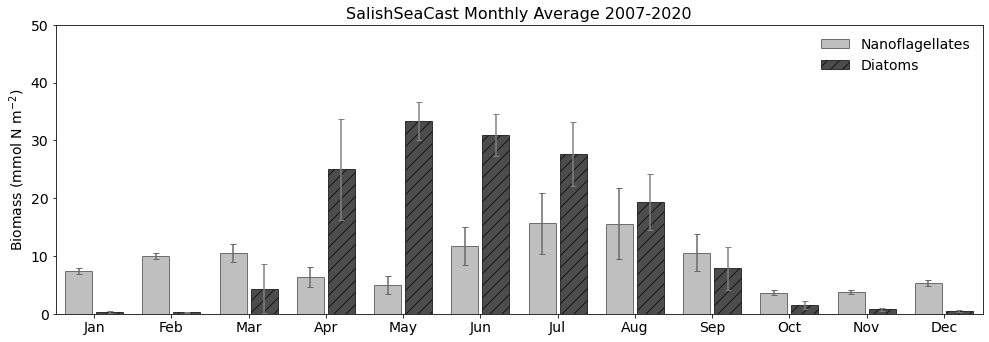

In [5]:
#Check data
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_diatom_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssc_flagellates_monthly_mean,width,yerr=ssc_flagellates_std,color='grey',ecolor='dimgrey',edgecolor='k',label='Nanoflagellates',alpha=0.5,capsize=3) 
ax.bar(xticks + 0.2, ssc_diatom_monthly_mean,width,yerr=ssc_diatom_std,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='Diatoms') 
ax.set_title('SalishSeaCast Monthly Average 2007-2020',fontsize=16)
ax.legend(frameon=False,loc=1,fontsize=14)
ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Biomass (mmol N m$^{-2}$)',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

### Read in corresponding SSAM diatoms, 100 m depth-integrated

In [6]:
# Central Strait of Gerorgia
central_sog_boxes = [81,82]

In [7]:
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
ssc_match_df = data_df.loc[central_sog_boxes]

grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
pointList = []
#boxCSoGcorners = (400,250), (450, 300), (900,300), (900,250), (450,250) #250, 450
boxSSCcorners = (0,0), (0, 400), (400,900), (900,0)
for i in boxCSoGcorners: 
    pointList.append(sgeom.Point(float(grid.nav_lon[i]), float(grid.nav_lat[i])))
bbox = sgeom.Polygon([[p.x, p.y] for p in pointList])


<AxesSubplot:>

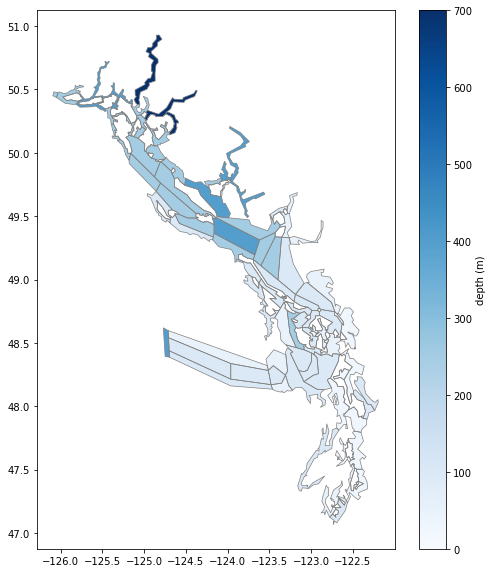

In [9]:
# Atlantis Location Map with SalishSeaCast Box Location
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 

ax = data_df.plot(column = 'BOTZ', ax=ax, cmap=cm.Blues, cax=cax,
    legend=True, legend_kwds={'label': 'depth (m)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
#ssc_match_df.plot(ax=ax, color='orange',  alpha=0.6, linewidths=0.5, label='matching Atlantis polygons')
land_df.plot(ax=ax, color='white')
#ax.annotate(0.81, 0.55, 'Matching\nAtlantis\nPolygons',transform=ax.transAxes, color='orange', fontsize=12)
#ax.text(0.27, 0.47, 'SalishSeaCast\nCentral SoG\nRegion',transform=ax.transAxes, color='black', fontsize=12)
#ax.text(0.05, 0.95, '(a)', transform=ax.transAxes, color='black', fontsize=14,) #fontweight='bold'
#bbox_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[bbox])
#bbox_gdf = bbox_gdf.to_crs(data_df.crs)
#bbox_gdf.boundary.plot(ax=ax, edgecolor='black', linewidths=2, linestyle="--", label='SalishSeaCast\nCentral SoG\nRegion');

In [10]:
#control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/MPRI-1/highres-control-3y/outputSalishSea.nc"
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/v6719_14y_20250703/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True) #.resample(t='1M').mean()


In [14]:
ssam_diatom_tbl = control.Diatom_N[:, groups.salish_sea, 3:6] # 100 m
ssam_diatom_t = ssam_diatom_tbl.sum(axis=(1,2))

ssam_picos_tbl = control.PicoPhytopl_N[:, groups.salish_sea, 3:6] # 100 m
ssam_picos_t = ssam_picos_tbl.sum(axis=(1,2))

In [26]:
# Biomass of picos much higher than diatoms in SSAM for this region. Correction for biomass to examine pattern.
ssam_diatom_t_corrected = ssam_diatom_t/(14*100) #(ssam_diatom_t-ssam_diatom_t.min())
ssam_picos_t_corrected = ssam_picos_t/(14*100) #(ssam_picos_t-ssam_picos_t.min())

In [27]:
ssam_diatom_monthly_mean = ssam_diatom_t_corrected.groupby("t.month").mean("t")
ssam_picos_monthly_mean = ssam_picos_t_corrected.groupby("t.month").mean("t")


In [28]:
ssam_diatom_std = ssam_diatom_t_corrected.groupby("t.month").std("t")
ssam_picos_std = ssam_picos_t_corrected.groupby("t.month").std("t")

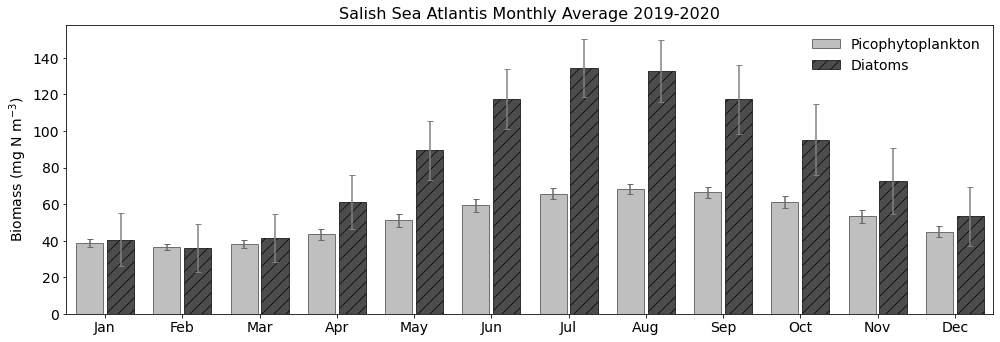

In [30]:
#Check data
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_diatom_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssam_picos_monthly_mean,width,yerr=ssam_picos_std,color='grey',ecolor='dimgrey',edgecolor='k',label='Picophytoplankton',alpha=0.5,capsize=3) 
ax.bar(xticks + 0.2, ssam_diatom_monthly_mean,width,yerr=ssam_diatom_std,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='Diatoms') 
ax.set_title('Salish Sea Atlantis Monthly Average 2019-2020',fontsize=16)
ax.legend(frameon=False,loc=1,fontsize=14)
#ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Biomass (mg N m$^{-3}$)',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

### Comparison figures

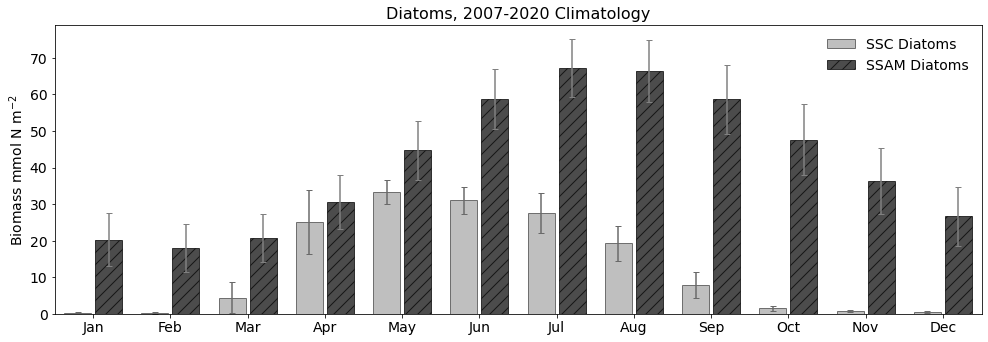

In [34]:
# Diatom biomass
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_diatom_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssc_diatom_monthly_mean,width,yerr=ssc_diatom_std,color='grey',ecolor='dimgrey',edgecolor='k',label='SSC Diatoms',alpha=0.5,capsize=3) #wheat
#ax.fill_between(xticks,NPGO_C_F_mean,color='dimgrey',alpha=.2,label='Nanoflagellates') #wheat
ax.bar(xticks + 0.2, ssam_diatom_monthly_mean/2,width,yerr=ssam_diatom_std/2,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='SSAM Diatoms') #lightgreen
#ax.fill_between(xticks,NPGO_C_D_mean,color='black',hatch='//',alpha=.3,label='Diatoms') #lightgreen
ax.set_title('Diatoms, 2007-2020 Climatology',fontsize=16)
ax.legend(frameon=False,fontsize=14, loc="upper right")
#ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Biomass mmol N m$^{-2}$',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#ax.text(-.25, 50, "(b)", color='k',fontsize=16)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

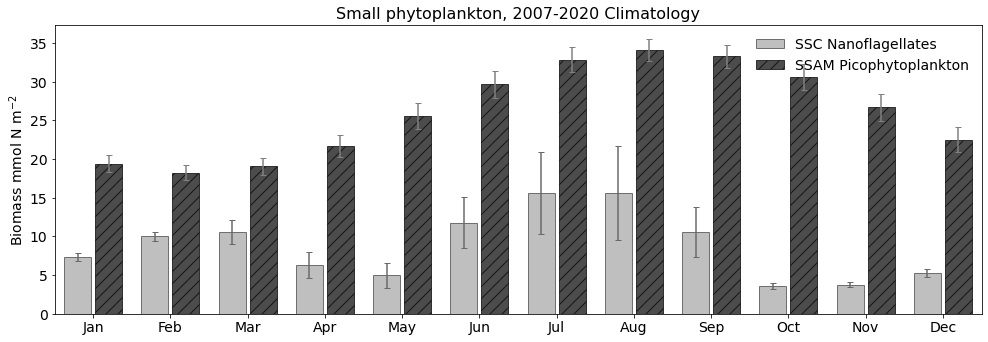

In [35]:
# Picophytoplankton biomass
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_diatom_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssc_flagellates_monthly_mean,width,yerr=ssc_flagellates_std,color='grey',ecolor='dimgrey',edgecolor='k',label='SSC Nanoflagellates',alpha=0.5,capsize=3) #wheat
#ax.fill_between(xticks,NPGO_C_F_mean,color='dimgrey',alpha=.2,label='Nanoflagellates') #wheat
ax.bar(xticks + 0.2, ssam_picos_monthly_mean/2,width,yerr=ssam_picos_std/2,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='SSAM Picophytoplankton') #lightgreen
#ax.fill_between(xticks,NPGO_C_D_mean,color='black',hatch='//',alpha=.3,label='Diatoms') #lightgreen
ax.set_title('Small phytoplankton, 2007-2020 Climatology',fontsize=16)
ax.legend(frameon=False,fontsize=14,loc='upper right') 
#ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Biomass mmol N m$^{-2}$',fontsize=14) 
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#ax.text(-.25, 45, "(c)", color='k',fontsize=16)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

### Comparison of SSAM Plankton to HPLC Data (Nemcek et al., 2023)

In [21]:
data_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/"
plankton_hplc_data = pd.read_csv(data_path+"Salish_Sea_Plankton_data.csv")


In [36]:
print('using data from '+ str(ssam_diatom_t.t[976])+' to '+str(ssam_diatom_t.t[1585]))

using data from <xarray.DataArray 't' ()>
array('2015-01-02T14:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2015-01-02T14:00:00 to <xarray.DataArray 't' ()>
array('2020-01-03T14:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    t        datetime64[ns] 2020-01-03T14:00:00


In [37]:
plankton_hplc_data['Diatoms1'].size

721

In [38]:
ssam_diatom_t[976:1697].size

721

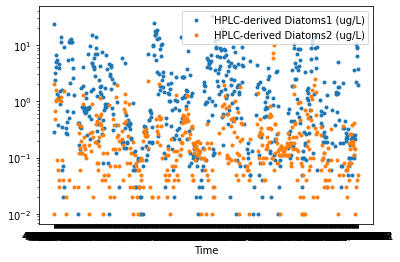

In [39]:
plt.semilogy(plankton_hplc_data['Date.Time'], plankton_hplc_data['Diatoms1'], '.')
#plt.scatter(control.t[976:1585], ssam_diatom_t[976:1585])
plt.semilogy(plankton_hplc_data['Date.Time'], plankton_hplc_data['Diatoms2'], '.')
plt.xlabel('Time')
#plt.ylabel()
#plt.title('Comparison of Diatoms')
plt.legend(['HPLC-derived Diatoms1 (ug/L)','HPLC-derived Diatoms2 (ug/L)']) #'Atlantis Diatoms (mg N/m${^3}$)',
plt.show()

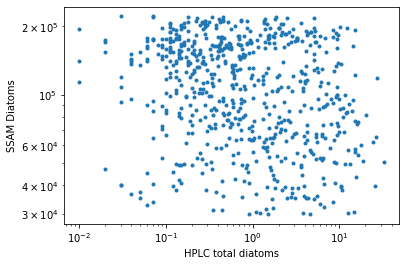

In [40]:
plt.loglog(plankton_hplc_data['total diatoms'], ssam_diatom_t[976:1697], '.')
#plt.scatter(control.t[976:1585], ssam_diatom_t[976:1585])
#plt.scatter(plankton_hplc_data['Date.Time'], plankton_hplc_data['Diatoms2'])
plt.xlabel('HPLC total diatoms')
plt.ylabel('SSAM Diatoms')
#plt.title('Comparison of Diatoms')
#plt.legend(['HPLC-derived Diatoms1 (ug/L)','Atlantis Diatoms (mg N/m${^3}$)','HPLC-derived Diatoms2 (ug/L)'])
plt.show()

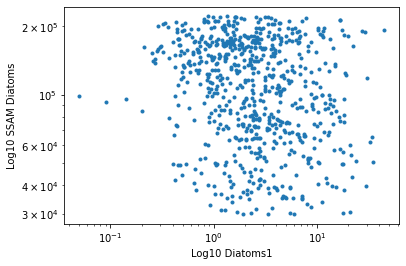

In [41]:
plt.loglog(plankton_hplc_data['Chlorophyll'], ssam_diatom_t[976:1697], '.')
#plt.scatter(control.t[976:1585], ssam_diatom_t[976:1585])
#plt.scatter(plankton_hplc_data['Date.Time'], plankton_hplc_data['Diatoms2'])
plt.xlabel('Log10 Diatoms1')
plt.ylabel('Log10 SSAM Diatoms')
#plt.title('Comparison of Diatoms')
#plt.legend(['HPLC-derived Diatoms1 (ug/L)','Atlantis Diatoms (mg N/m${^3}$)','HPLC-derived Diatoms2 (ug/L)'])
plt.show()

In [43]:
ssam_diatom_df_tbl = control.Diatom_N[976:1585, :, 3:6] # 100 m
ssam_diatom_df_tb = ssam_diatom_df_tbl.sum(axis=2)
ssam_diatom_df_b = ssam_diatom_df_tb.mean(axis=0)

In [44]:
data_df['diatoms'] = ssam_diatom_df_b

In [45]:
# Loading the HPLC dataset into a Geopandas Dataframe
plankton_hplc_data_df = pd.read_csv(data_path+"Salish_Sea_Plankton_data.csv")
hplc_df = gpd.GeoDataFrame(
    plankton_hplc_data_df, 
    geometry=gpd.points_from_xy(plankton_hplc_data_df.Lon, plankton_hplc_data_df.Lat),
    crs="EPSG:4326")
hplc_df = hplc_df.to_crs(data_df.crs)

In [46]:
hplc_df['diatoms'] = hplc_df['Diatoms1'] + hplc_df['Diatoms2']

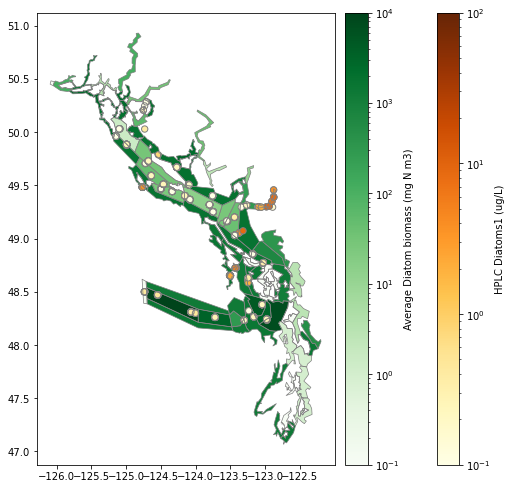

In [47]:
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
cax2 = divider.append_axes("right", size="5%", pad=0.95) 
ax = data_df.plot(column = 'diatoms', ax=ax, cax=cax, cmap=cm.Greens, #vmax=100,
    norm=colors.LogNorm(vmin=1e-1, vmax=1e4),
    legend=True, legend_kwds={'label': 'Average Diatom biomass (mg N m3)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
land_df.plot(ax=ax, color='white')

hplc_df.plot(ax=ax, cax=cax2, column='Diatoms1', cmap='YlOrBr', markersize=40, edgecolor='grey', #alpha=0.6,
    norm=colors.LogNorm(vmin=1e-1, vmax=1e2),
    legend=True, legend_kwds={'label': 'HPLC Diatoms1 (ug/L)'},);


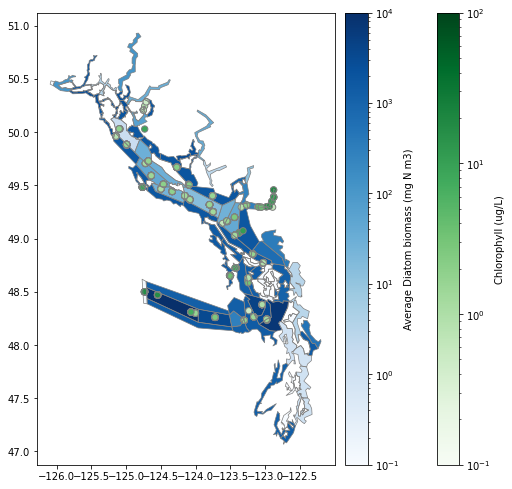

In [48]:
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95) 
cax2 = divider.append_axes("right", size="5%", pad=0.95) 
ax = data_df.plot(column = 'diatoms', ax=ax, cax=cax, cmap=cm.Blues, #vmax=100,
    norm=colors.LogNorm(vmin=1e-1, vmax=1e4),
    legend=True, legend_kwds={'label': 'Average Diatom biomass (mg N m3)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
land_df.plot(ax=ax, color='white')

hplc_df.plot(ax=ax, cax=cax2, column='Chlorophyll', cmap='Greens', markersize=40, edgecolor='grey', #alpha=0.6,
    norm=colors.LogNorm(vmin=1e-1, vmax=1e2),
    legend=True, legend_kwds={'label': 'Chlorophyll (ug/L)'},);
